In [1]:
# import necessary libraries for unsupervised learning
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [2]:
# load the csv file and view the entries/rows at the top
df = pd.read_csv("Top-100 Trending Books.csv")
df.head()

,Rank,book title,book price,rating,author,year of publication,genre,url
0,1,"Iron Flame (The Empyrean, 2)",18.42,4.1,Rebecca Yarros,2023,Fantasy Romance,amazon.com/Iron-Flame-Empyrean-Rebecca-Yarros/...
1,2,The Woman in Me,20.93,4.5,Britney Spears,2023,Memoir,amazon.com/Woman-Me-Britney-Spears/dp/16680090...
2,3,My Name Is Barbra,31.50,4.5,Barbra Streisand,2023,Autobiography,amazon.com/My-Name-Barbra-Streisand/dp/0525429...
3,4,"Friends, Lovers, and the Big Terrible Thing: A...",23.99,4.4,Matthew Perry,2023,Memoir,amazon.com/Friends-Lovers-Big-Terrible-Thing/d...
4,5,How to Catch a Turkey,5.65,4.8,Adam Wallace,2018,"Childrens, Fiction",amazon.com/How-Catch-Turkey-Adam-Wallace/dp/14...


In [3]:
# information overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Rank                 100 non-null    int64  
 1   book title           100 non-null    object 
 2   book price           100 non-null    float64
 3   rating               97 non-null     float64
 4   author               100 non-null    object 
 5   year of publication  100 non-null    int64  
 6   genre                100 non-null    object 
 7   url                  100 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 6.4+ KB


In [4]:
# take a look at the missing entries
missing = df.isna().any()
missing

Rank                   False
book title             False
book price             False
rating                  True
author                 False
year of publication    False
genre                  False
url                    False
dtype: bool

In [5]:
# another syntax of looking at missing entries
alternative_missing = df.isnull().sum()
alternative_missing

Rank                   0
book title             0
book price             0
rating                 3
author                 0
year of publication    0
genre                  0
url                    0
dtype: int64

In [6]:
# printing the column that has the missing rows for context
rating = df['rating']
print(rating)

0     4.1
1     4.5
2     4.5
3     4.4
4     4.8
     ... 
95    4.7
96    4.7
97    4.5
98    4.6
99    4.8
Name: rating, Length: 100, dtype: float64


In [7]:
# locating the missing entries in the rating column
missing_rating = df[df['rating'].isna()] 
print(missing_rating)

    Rank                                         book title  book price  \
24    25       House of Flame and Shadow (Crescent City, 3)       18.48   
45    46  How to Be the Love You Seek: Break Cycles, Fin...       20.11   
85    86                                   Love Comes First       17.99   

    rating         author  year of publication  \
24     NaN  Sarah J. Maas                 2023   
45     NaN  Nicole LePera                 2023   
85     NaN   Emily Giffin                 2016   

                                                genre  \
24  Fantasy, Dragons, Young Adult, Fiction, High F...   
45  Self Help, Nonfiction, Mental Health, Psycholo...   
85  Fiction, Romance, Contemporary, Audiobook, Adu...   

                                                  url  
24  amazon.com/House-Flame-Shadow-Crescent-City/dp...  
45  amazon.com/How-Love-You-Seek-Relationships/dp/...  
85  amazon.com/Love-Comes-First-Jenna-Hager/dp/031...  


In [8]:
# random look about to see if i can use forward fill to clean the NaN data
print(df.iloc[23], df.iloc[44], df.iloc[84])

Rank                                                                  24
book title                                                 A Little Life
book price                                                         11.83
rating                                                               4.5
author                                                  Hanya Yanagihara
year of publication                                                 2015
genre                  Fiction, Contemporary, LGBT, Literary Fiction,...
url                    amazon.com/Little-Life-Hanya-Yanagihara/dp/080...
Name: 23, dtype: object Rank                                                                  45
book title                   I Am Thankful: A Thanksgiving Book for Kids
book price                                                          7.99
rating                                                               4.7
author                                                        Sheri Wall
year of publication        

In [9]:
# hmm i don't think forward fill would be ideal...a quick look through df.info() shows it's not progressive as we go downwards. 
# so mean would probably work best
# approximating to 1 decimal place to keep in line with the other entries
df['rating'].fillna(round(df['rating'].mean(), 1), inplace=True)
print(df.iloc[24], df.iloc[45], df.iloc[85])

Rank                                                                  25
book title                  House of Flame and Shadow (Crescent City, 3)
book price                                                         18.48
rating                                                               4.7
author                                                     Sarah J. Maas
year of publication                                                 2023
genre                  Fantasy, Dragons, Young Adult, Fiction, High F...
url                    amazon.com/House-Flame-Shadow-Crescent-City/dp...
Name: 24, dtype: object Rank                                                                  46
book title             How to Be the Love You Seek: Break Cycles, Fin...
book price                                                         20.11
rating                                                               4.7
author                                                     Nicole LePera
year of publication        

In [10]:
# data cleaned...TF-IDF vectorization would be next, but we have no description column. genres could be used but it's quite limited.
# let's add descriptions
import requests
import time

def fetch_description(title, author):
    query = f"{title} {author}"
    url = f"https://openlibrary.org/search.json?q={requests.utils.quote(query)}"
    try:
        response = requests.get(url)
        data = response.json()
        if 'docs' in data and len(data['docs']) > 0:
            work_key = data['docs'][0].get('key')
            if work_key:
                work_url = f"https://openlibrary.org{work_key}.json"
                work_response = requests.get(work_url).json()
                return work_response.get('description', '')
    except Exception as e:
        print(f"Error fetching {title}: {e}")
    return ''

# Example usage on a dataframe
df['description'] = df.apply(lambda row: fetch_description(row['book title'], row['author']), axis=1)


In [11]:
description = df['description']
print(description)

0                                                      
1     {'type': '/type/text', 'value': 'The Woman in ...
2                                                      
3                                                      
4                                                      
                            ...                        
95                                                     
96                                                     
97    {'type': '/type/text', 'value': 'a true tale o...
98                                                     
99    While walking down the road, the narrator sees...
Name: description, Length: 100, dtype: object


In [12]:
# even with the addition of a description column via an external source, it is not very clean as there are some missing entries.so i will combine existing features
df['text_features'] = df['book title'] + " " + df['genre']
# Apply TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = vectorizer.fit_transform(df['text_features'])

print(tfidf_matrix.shape)  # Checking matrix size

(100, 478)


In [13]:
# KMeans Clustering
num_clusters = 10 # you could easily as well fit 10 as the argument for the n_clusters under KMeans...
kmeans = KMeans(10, random_state=42)
kmeans.fit(tfidf_matrix)
df['cluster'] = kmeans.labels_

In [14]:
# reducing dimensions to 2D using PCA
pca = PCA(n_components=2, random_state=42)
tfidf_matrix_reduced = pca.fit_transform(tfidf_matrix.toarray())

In [15]:
# a quick look around of the clusters (the unlabeled microgenres)
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}")
    cluster_data = df[df['cluster'] == cluster_num]
    
    # Check if the cluster has at least 5 rows, otherwise sample all rows
    sample_size = min(5, len(cluster_data))
    
    if sample_size > 0:  # Make sure the cluster is not empty
        sample = cluster_data.sample(sample_size, random_state=42)
        print(sample[['genre', 'text_features']])
    


Cluster 0
                                                genre  \
16                        Fiction, Historical Fiction   
37                  Picture Books, Childrens, Holiday   
88                                          Self Help   
38  Finance, Nonfiction, Psychology, Business, Sel...   
57                              Self Help, Psychology   

                                        text_features  
16  Lessons in Chemistry: A Novel Fiction, Histori...  
37  The Psychology of Money: Timeless lessons on w...  
88  The Shadow Work Journal 2nd Edition: a Guide t...  
38  The Seven Husbands of Evelyn Hugo: A Novel Fin...  
57  The Shadow Work Journal: A Guide to Integrate ...  

Cluster 1
                       genre  \
55         Fiction, Alphabet   
73                 Childrens   
18  Picture Books, Biography   
94                 Childrens   
31              Picture Book   

                                        text_features  
55  Chicka Chicka Boom Boom (Board Book) Fiction, 

In [16]:
# Build dictionary mapping cluster number → dominant microgenre
cluster_to_microgenre = {}
for cluster_num in range(num_clusters):
    dominant = df[df['cluster'] == cluster_num]['genre'].value_counts().idxmax()
    cluster_to_microgenre[cluster_num] = dominant

In [17]:
component_1 = pca.components_[0]
component_2 = pca.components_[1]
# Get feature names (i.e., words)
words = vectorizer.get_feature_names_out()
# Top 15 influential words for each component
top_indices_1 = np.argsort(component_1)[-15:]
top_indices_2 = np.argsort(component_2)[-15:]
print("Top words for PCA Component 1:")
print(words[top_indices_1][::-1])
print("\nTop words for PCA Component 2:")
print(words[top_indices_2][::-1])

Top words for PCA Component 1:
['childrens' 'books' 'picture' 'animals' 'holiday' 'storytime' 'humor'
 'catch' 'turkey' 'fiction' 'christmas' 'book' 'kids' 'just' 'poetry']

Top words for PCA Component 2:
['fantasy' 'adult' 'fiction' 'court' 'romance' 'thorns' 'roses'
 'contemporary' 'young' 'box' 'paperback' 'set' 'thriller' 'new' 'mystery']


In [18]:
# Create mapping from cluster number to most frequent genre in that cluster
cluster_to_genre = {}

for cluster_num in range(num_clusters):
    cluster_genres = df[df['cluster'] == cluster_num]['genre']
    most_common_genre = cluster_genres.mode()[0] if not cluster_genres.mode().empty else "Unknown"
    cluster_to_genre[cluster_num] = most_common_genre

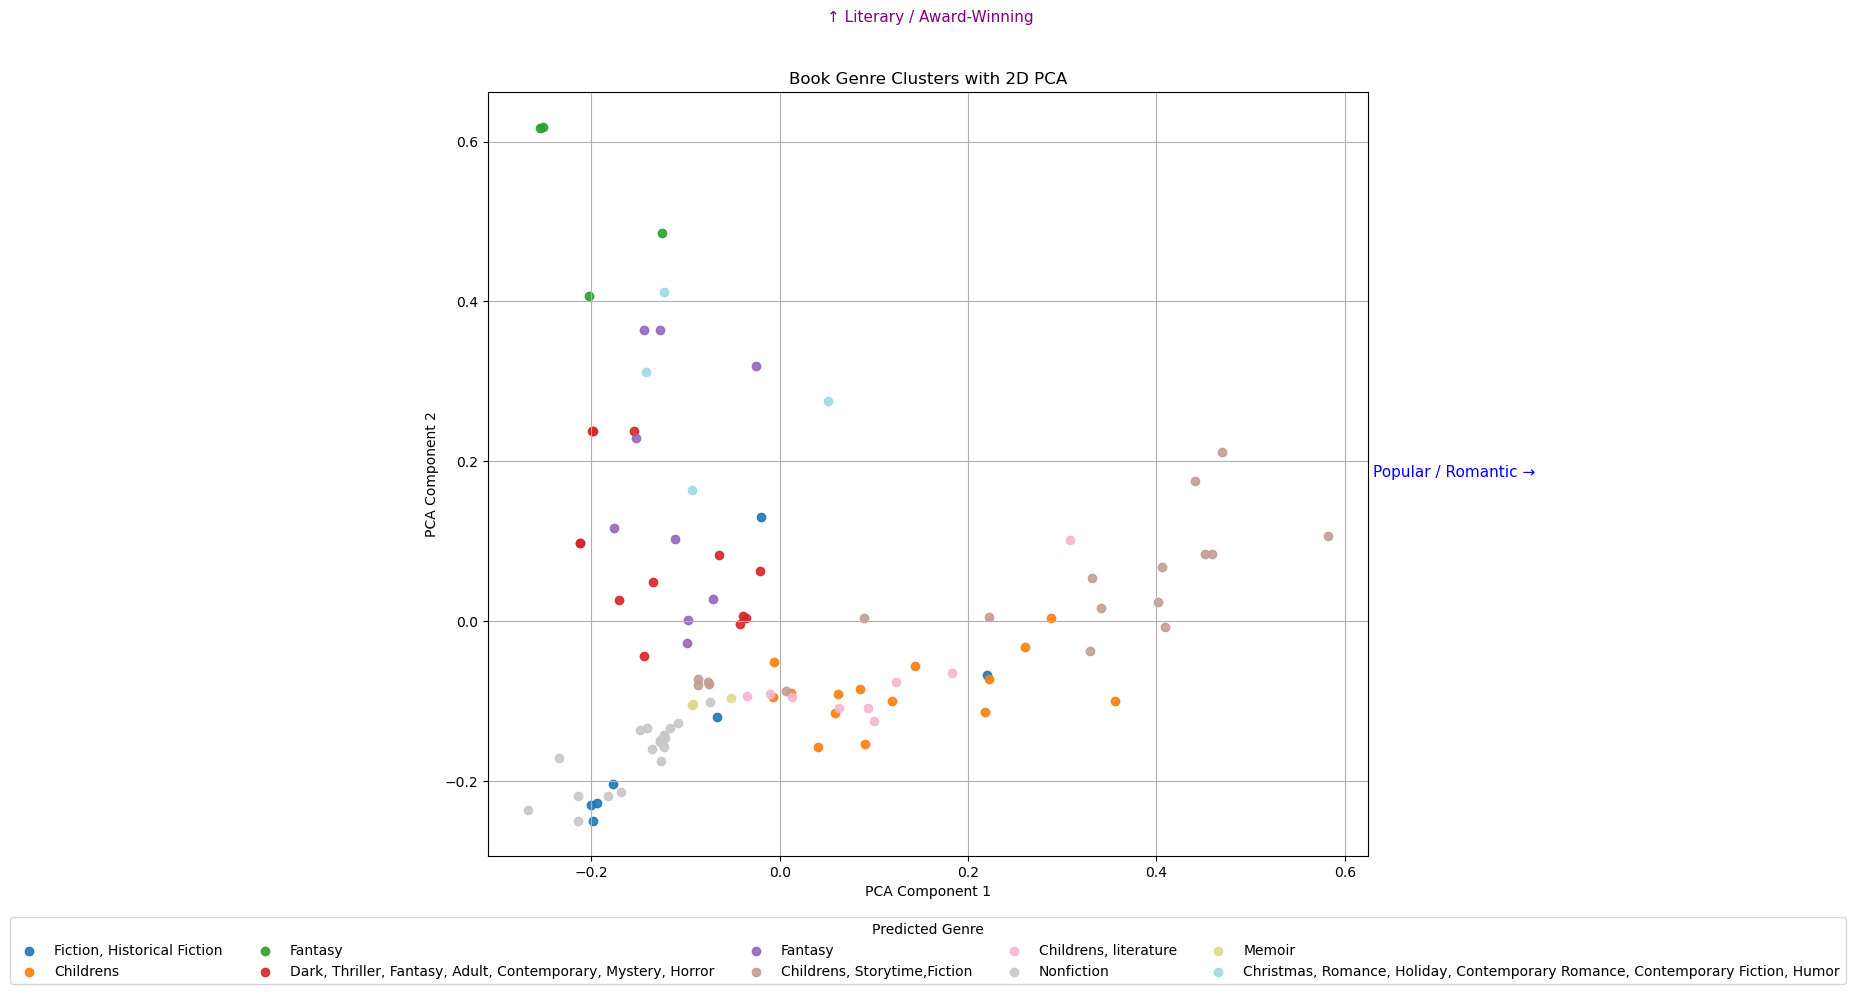

In [93]:
colormap = plt.get_cmap('tab20', num_clusters)
colors = [colormap(i) for i in range(num_clusters)]
plt.figure(figsize=(17, 12))

for cluster_num in range(num_clusters):
    cluster_points = tfidf_matrix_reduced[df['cluster'] == cluster_num]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors[cluster_num], label=cluster_to_genre[cluster_num], alpha=0.9)

plt.title('Book Genre Clusters with 2D PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')


plt.annotate('Popular / Romantic →', xy=(0.42, 0), xytext=(0.63, 0.18), fontsize=11, color='blue')
plt.annotate('← Serious / Thought-Provoking', xy=(-0.5, 0), xytext=(-1.0, 0.2), fontsize=11, color='red')
plt.annotate('↑ Literary / Award-Winning', xy=(0, 0.5), xytext=(0.05, 0.75), fontsize=11, color='purple')
plt.annotate('↓ Genre Fiction / Mass Appeal', xy=(0, -0.5), xytext=(0, -1.0), fontsize=11, color='green')


plt.legend(title='Predicted Genre', bbox_to_anchor=(0.5, -0.08), loc='upper center', borderaxespad=0., ncol=num_clusters // 2 if num_clusters > 2 else 2)

plt.tight_layout(rect=[0.08, 0.12, 0.92, 0.95])
plt.subplots_adjust(bottom=0.22)
plt.grid(True)
plt.show()
